<div style="text-align: center; padding: 2em;">
    <h3>Master of Science in quantitative and financial modeling</h3>
    <h4>'Devoir Pratiques'</h4>
    <span>
        EXAMINER: Prof. I. Kissami&nbsp;&nbsp;&nbsp;&nbsp;-&nbsp;&nbsp;&nbsp;&nbsp;
        Due date: Monday April 16 2024
    </span>
    <br>
    <br>
    FAMILY NAME: AKOTENOU<br>
    GIVEN NAMES: Généreux Mahouzonssou<br>
    email: Mahouzonssou.AKOTENOU@um6p.ma
</div>

<hr>

In [1]:
"""
En exécutant tout ce notebook, le dossier 'submit' sera créé et il contiendra les fichiers Python de chaque exercice.
On pourra par la suite utiliser la commande suivante pour exécuter chaque script et voir les sorties :

$ mpirun -n <number> python3 <filename.py>
"""
import os
directory = 'submit'
if not os.path.exists(directory):
    os.makedirs(directory)

* Exercice 3

In [2]:
%%file submit/exo3.py

from mpi4py import MPI
import numpy as np
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

assert SIZE >= 1, "The number of process should be at least 1"

# Set Problem Data
n = 300

# Initialize matrix on process 0 and scatter part
if RANK == 0:
    matrix = np.random.rand(n, n)
    diag_element = np.diag(matrix)
    diag_array   = np.array_split(diag_element, SIZE)
else:
    diag_array = None

sub_diag  = COMM.scatter(diag_array, root=0)
sub_trace = np.sum(sub_diag)

# Process 0 get all sub trace and sum it
COMM.Barrier()
glob_trace = COMM.reduce(sub_trace, op=MPI.SUM, root=0)
if RANK == 0:
    print(f"Parralel Trace = {glob_trace}")
    print(f"Numpy Trace = {np.trace(matrix)}")

Overwriting submit/exo3.py


In [3]:
# OUTPUT
# % mpirun -n 3 python3 submit/exo3.py
#
# Parralel Trace = 149.28017276615748
# Numpy Trace = 149.28017276615748

* Exercice 4

In [4]:
%%file submit/utils.py

"""
IMPORTANT: We must copy "utils" file provided for poisson exercise in the current folder ('submit') so our script just bellow 
will work perfectly

TODOs: Just run this cell to get the utils file created 
"""

from sympy.ntheory import factorint
import numpy.ma as ma
import numpy as np

def compute_dims_uniform( mpi_size, npts ):

    nprocs = [1]*len( npts )

    mpi_factors   = factorint( int(mpi_size) )
    npts_factors  = [factorint( int(n) ) for n in npts]

    nprocs = [1 for n in npts]

    for a,power in mpi_factors.items():

        exponents = [f.get( a, 0 ) for f in npts_factors]

        for k in range( power ):

            i = np.argmax( exponents )
            max_exp = exponents[i]

            if exponents.count( max_exp ) > 1:
                i = ma.array( nprocs, mask=np.not_equal( exponents, max_exp ) ).argmin()

            nprocs   [i] *= a
            exponents[i] -= 1

            npts_factors[i][a] -= 1

    shape = [np.prod( [key**val for key,val in f.items()] ) for f in npts_factors]

    return nprocs, shape

def compute_dims_general( mpi_size, npts ):

    nprocs = [1]*len( npts )
    shape  = [n for n in npts]

    f = factorint( mpi_size, multiple=True )
    f.sort( reverse=True )

    for a in f:

        i = np.argmax( shape )
        max_shape = shape[i]

        if shape.count( max_shape ) > 1:
            i = ma.array( nprocs, mask=np.not_equal( shape, max_shape ) ).argmin()

        nprocs[i]  *= a
        shape [i] //= a

    return nprocs, shape

def compute_dims( nnodes, gridsizes, min_blocksizes=None, mpi=None ):

    assert nnodes > 0
    assert all( s > 0 for s in gridsizes )
    assert np.prod( gridsizes ) >= nnodes

    if (min_blocksizes is not None):
        assert len( min_blocksizes ) == len( gridsizes )
        assert all( m > 0 for m in gridsizes )
        assert all( s >= m for s,m in zip( gridsizes, min_blocksizes ) )

    # Determine whether uniform decomposition is possible
    uniform = (np.prod( gridsizes ) % nnodes == 0)

    # Compute dimensions of MPI Cartesian topology with most appropriate algorithm
    if uniform:
        dims, blocksizes = compute_dims_uniform( nnodes, gridsizes )
    else:
        dims, blocksizes = compute_dims_general( nnodes, gridsizes )

    # If a minimum block size is given, verify that condition is met

    if min_blocksizes is not None:
        too_small = any( [s < m for (s,m) in zip( blocksizes, min_blocksizes )] )

        # If uniform decomposition yields blocks too small, fall back to general algorithm
        if uniform and too_small:
            dims, blocksizes = compute_dims_general( nnodes, gridsizes )
            too_small = any( [s < m for (s,m) in zip( blocksizes, min_blocksizes )] )

        # If general decomposition yields blocks too small, raise error
        if too_small:
            raise ValueError("Cannot compute dimensions with given input values!")

    return dims, blocksizes

Overwriting submit/utils.py


In [7]:
%%file submit/exo4.py

from mpi4py import MPI
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import time

"""
IMPORTANT: We must copy "utils" file provided for poisson exercise in the current folder
"""
from utils import compute_dims

# Initialize comm utils
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Utils
def solve_2d_diff(u, un, nt, dt, dx, dy, nu):
    # Assign initial conditions - set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    row, col  = u.shape
    coord     = cart2d.Get_coords(RANK)
    row_start = coord[0]*blocksizes[0]
    row_end   = coord[0]*blocksizes[0] + blocksizes[0]
    col_start = coord[1]*blocksizes[1]
    col_end   = coord[1]*blocksizes[1] + blocksizes[1]
    for i, iter_y in enumerate(range(row_start, row_end)):
        for j, iter_x in enumerate(range(col_start, col_end)):
            if 0.5 <= iter_y*dy <= 1.0 and 0.5 <= iter_x*dx <= 1.0:
                u[1:-1, 1:-1][i, j] = 2

    # Some constante
    c1 = (nu*dt) / dx**2
    c2 = (nu*dt) / dy**2

    # Derived type
    type_line = MPI.DOUBLE.Create_contiguous(u.shape[1]-2)
    type_line.Commit()

    # Fill the update of u
    for n in range(nt):
        un = u.copy()

        # Exchange boundary information
        TOP_PROCESS, BOTTOM_PROCESS = cart2d.Shift(direction=0, disp=1)
        LEFT_PROCESS, RIGHT_PROCESS = cart2d.Shift(direction=1, disp=1)
        
        cart2d.Sendrecv([un[1, 1:-1], 1, type_line],  dest=TOP_PROCESS, recvbuf=[un[-1, 1:-1], 1, type_line], source=BOTTOM_PROCESS)
        cart2d.Sendrecv([un[-2, 1:-1], 1, type_line], dest=BOTTOM_PROCESS, recvbuf=[un[0, 1:-1], 1, type_line], source=TOP_PROCESS)
        
        right_col_buff = np.zeros(u.shape[0]-2)
        cart2d.Sendrecv(np.ascontiguousarray(un[1:-1, 1]), dest=LEFT_PROCESS, recvbuf=right_col_buff, source=RIGHT_PROCESS)
        un[1:-1, -1] = right_col_buff

        left_col_buff = np.zeros(u.shape[0]-2)
        cart2d.Sendrecv(np.ascontiguousarray(un[1:-1, -2]), dest=RIGHT_PROCESS, recvbuf=left_col_buff, source=LEFT_PROCESS)
        un[1:-1, 0] = left_col_buff
        
        # Update new state
        for i in range(1, nx-1): 
            for j in range(1, ny-1):
                u[i, j] = un[i, j] + c1*(un[i+1, j] - 2*un[i, j] + un[i-1, j]) + c2*(un[i, j+1] - 2*un[i, j] + un[i, j-1])
    
    return 0


###variable declarations
nt = 51
nx = 101
ny = 101 
nu = .05
dx = 2 / (nx -1)
dy = 2 / (ny -1)
sigma = .25
dt = sigma * dx * dy / nu

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

# create a 1xn vector of 1's
u = np.ones((ny, nx)) 
un = np.ones((ny, nx))

# ------------------------------------------------
# Parallel paradigm: Let solve and plot solution
# ------------------------------------------------

# a) Let create a cartesian topology
dims, blocksizes = compute_dims(SIZE, [nx, ny])
cart2d  = COMM.Create_cart(dims=dims, periods=None, reorder=False)

# a) We setup new values for nx, ny as domaine change
nx = blocksizes[0]+2
ny = blocksizes[1]+2

# a) We cut u to mach it process gridsize and add ghost_cells
u_local  = np.zeros((blocksizes[0] + 2, blocksizes[1] + 2))
u_local[1:-1, 1:-1] = np.ones((blocksizes[0], blocksizes[1]))
un_local = np.zeros((blocksizes[0] + 2, blocksizes[1] + 2))
un_local[1:-1, 1:-1] = np.ones((blocksizes[0], blocksizes[1]))

# b-c) init u locally and exchage boundary information
solve_2d_diff(u_local, un_local, nt, dt, dx, dy, nu)

# d) Get data on process 0 and display
COMM.Barrier()
all_local_u = COMM.gather(u_local , root=0)
if RANK == 0:
    # Reconstruct initial matrix
    for j in range(SIZE):
        coord = cart2d.Get_coords(j)
        row_start = coord[0]*blocksizes[0]
        row_end   = coord[0]*blocksizes[0] + blocksizes[0]
        col_start = coord[1]*blocksizes[1]
        col_end   = coord[1]*blocksizes[1] + blocksizes[1]
        u[row_start:row_end, col_start:col_end] = all_local_u[j][1:-1,1:-1]
        print(u)

    # Visualization
    fig = pyplot.figure(figsize=(7, 5), dpi=100)
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(x, y)
    surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('U')
    ax.set_title('3D Surface Plot')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    pyplot.show()

Overwriting submit/exo4.py


In [1]:
# OUTPUT 
# % mpirun -n 4 python3 submit/exo4.py 

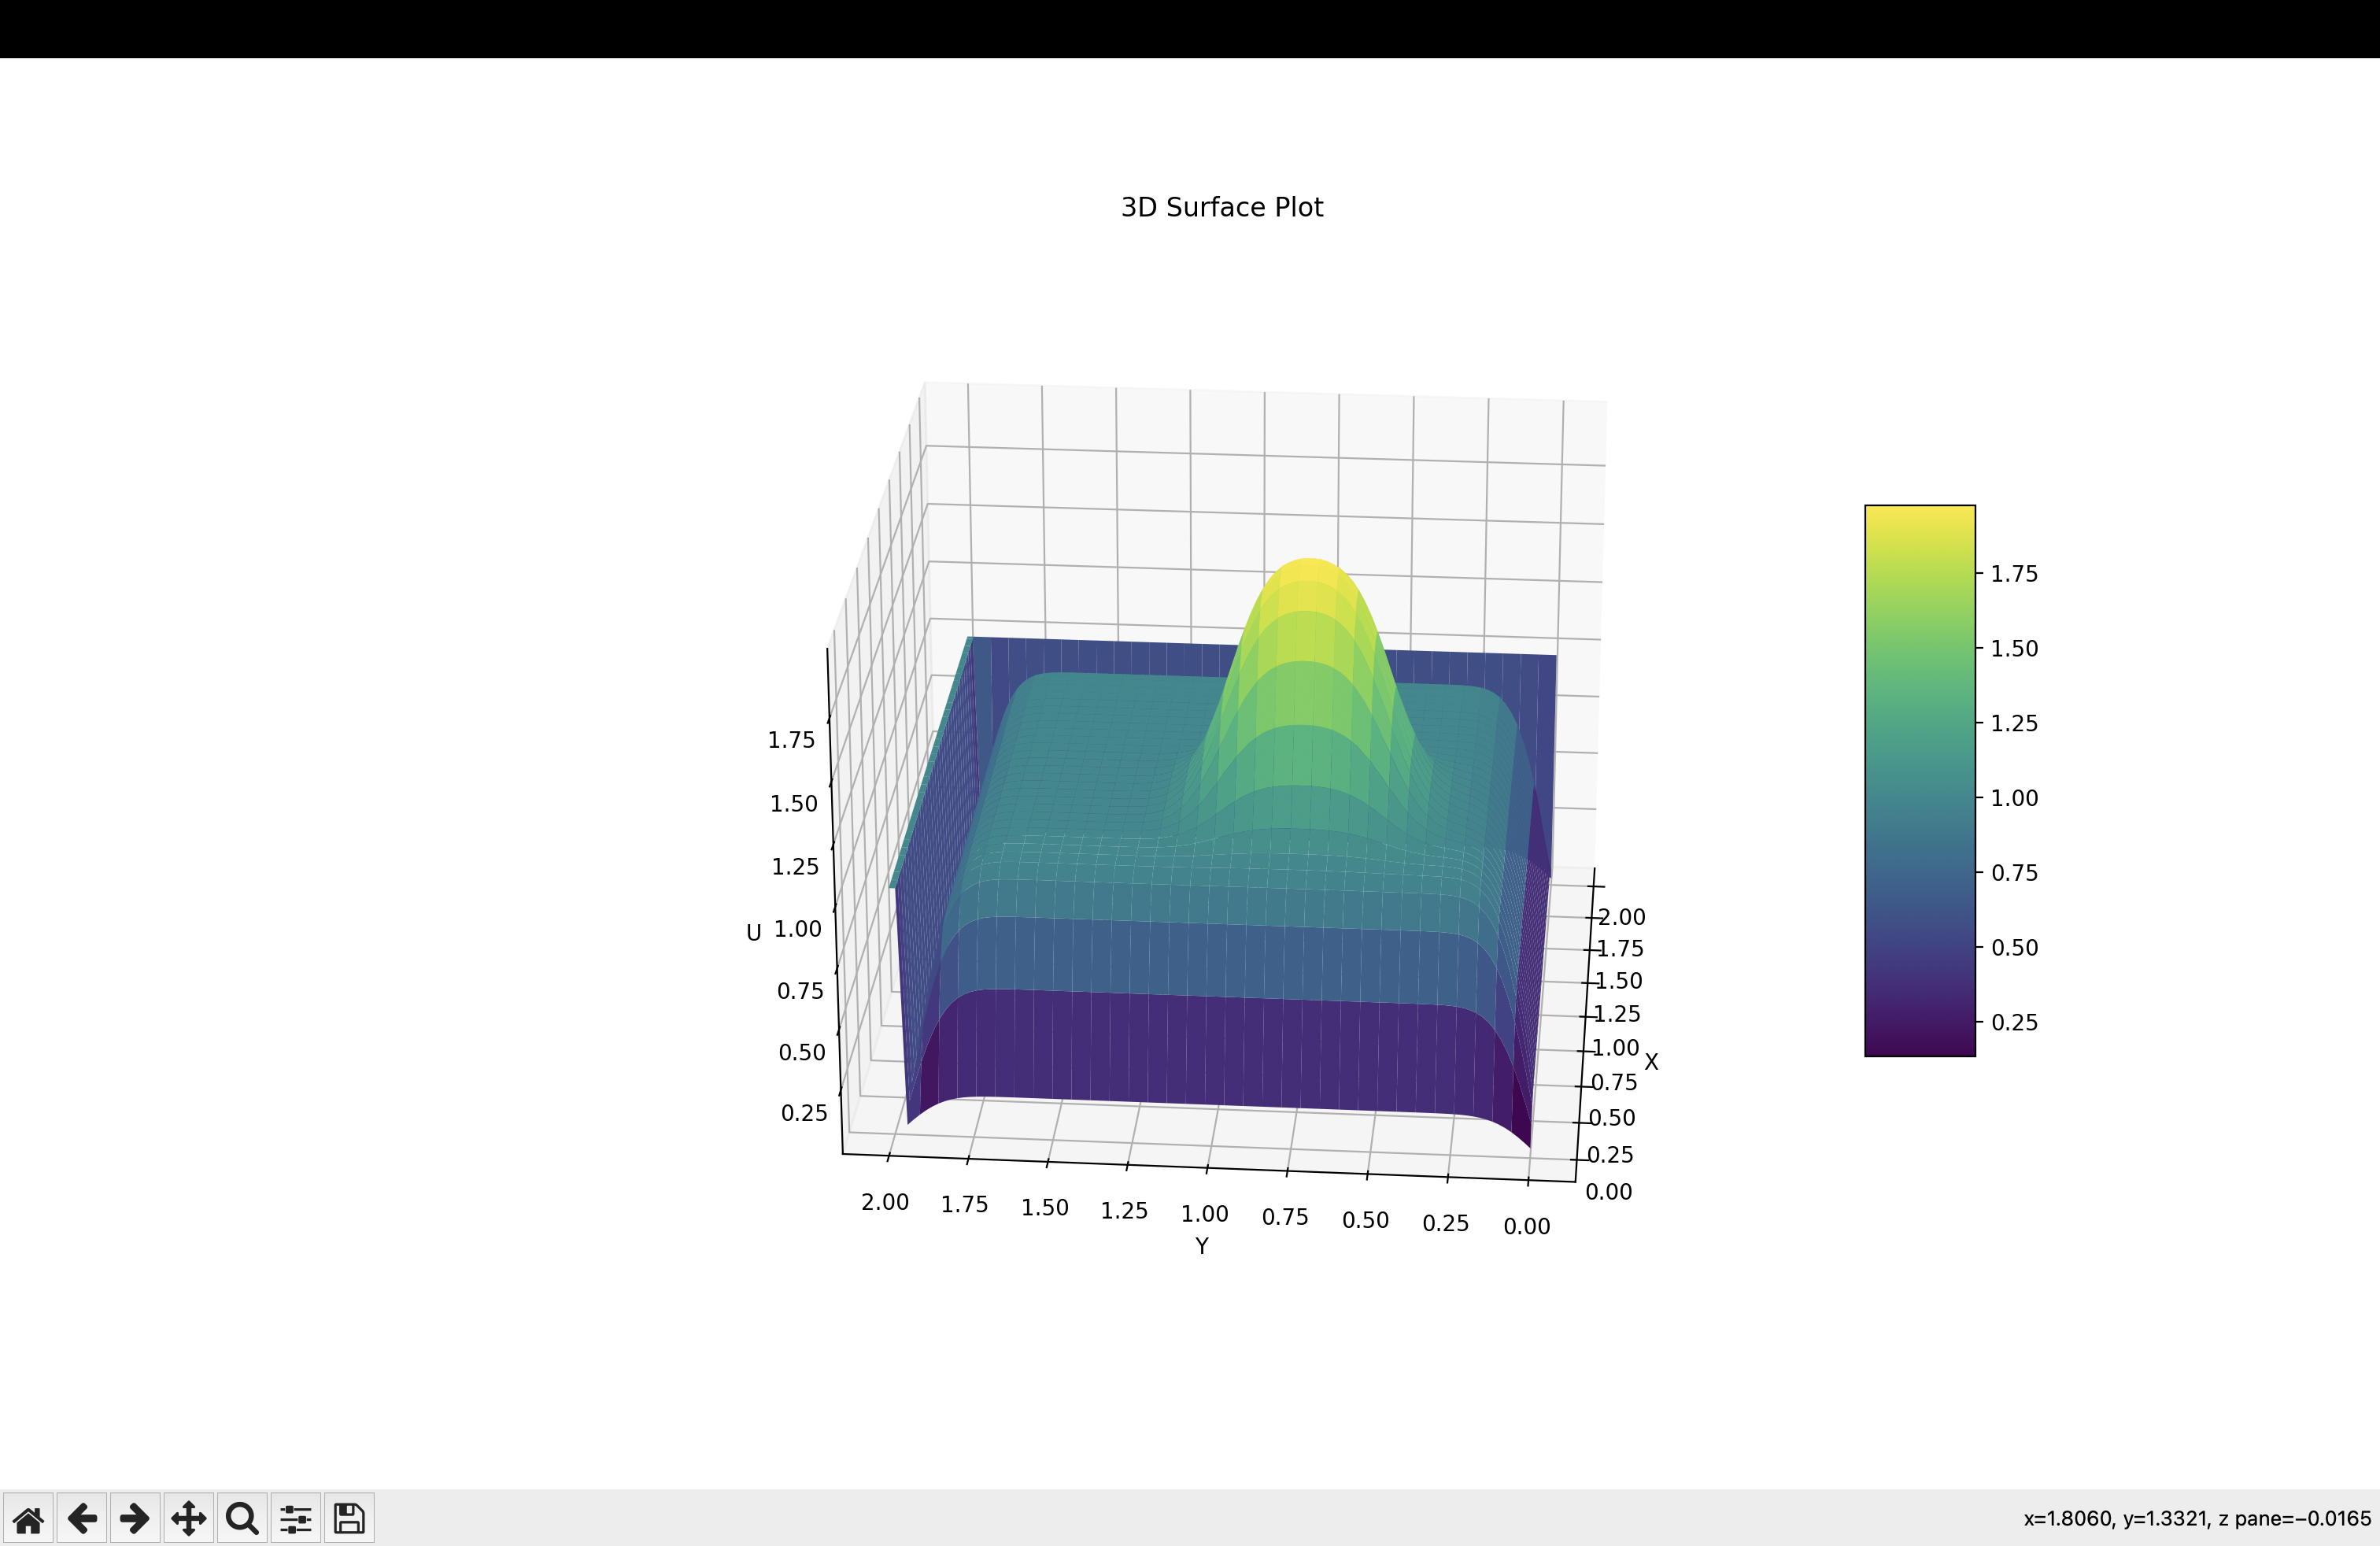